In [1]:
import os
import glob
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class LowLightDataset(Dataset):
    def __init__(self, lr_dir, hr_dir=None, transform=None):
        """
        lr_dir: Path to low-resolution, noisy images (e.g., 'archive/train/train')
        hr_dir: Path to high-resolution, clean images (e.g., 'archive/train/gt')
                If hr_dir is None, it means we're in test mode (no ground truth).
        transform: Optional transforms to apply.
        """
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        
        # Collect all filenames from the LR folder
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, '*.png')))
        
        # If we have ground truth images, gather them too
        if hr_dir is not None:
            self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, '*.png')))
        else:
            self.hr_paths = None

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        # Load LR (noisy) image
        lr_path = self.lr_paths[idx]
        lr_img = Image.open(lr_path).convert('RGB')
        
        if self.hr_paths is not None:
            # Load HR (ground truth) image
            hr_path = self.hr_paths[idx]
            hr_img = Image.open(hr_path).convert('RGB')
        else:
            hr_img = None
        
        # Apply transforms
        if self.transform:
            lr_img = self.transform(lr_img)
            if hr_img is not None:
                hr_img = self.transform(hr_img)
        
        if hr_img is not None:
            return lr_img, hr_img
        else:
            return lr_img

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return x + self.block(x)

class SuperResolutionDenoiseNet(nn.Module):
    def __init__(self, upscale_factor=4, num_res_blocks=5):
        super(SuperResolutionDenoiseNet, self).__init__()
        
        # Initial feature extraction
        self.input_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Denoising residual blocks
        self.denoise_res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_res_blocks)]
        )
        
        self.denoise_conv = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Skip connection back to original input
        self.denoise_out = nn.Conv2d(64, 3, kernel_size=3, padding=1)

        # Super-resolution block
        self.sr_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.sr_res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_res_blocks)]
        )
        self.sr_conv2 = nn.Conv2d(64, (upscale_factor ** 2) * 3, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        # Denoising path
        x_feat = self.input_conv(x)
        x_denoised = self.denoise_res_blocks(x_feat)
        x_denoised = self.denoise_conv(x_denoised) + x_feat  # Global residual
        x_denoised = self.denoise_out(x_denoised)

        # Super-resolution path
        x_sr = F.relu(self.sr_conv1(x_denoised))
        x_sr = self.sr_res_blocks(x_sr)
        x_sr = self.sr_conv2(x_sr)
        x_sr = self.pixel_shuffle(x_sr)
        return x_sr

In [4]:
def psnr(pred, gt, max_pixel_value=1.0):
    mse = F.mse_loss(pred, gt)
    if mse == 0:
        return 100
    return 20 * math.log10(max_pixel_value / math.sqrt(mse.item()))

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4):
    model = model.cuda()
    criterion = nn.L1Loss()  # L1 Loss for better sharpness
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            lr_imgs, hr_imgs = lr_imgs.cuda(), hr_imgs.cuda()
            
            optimizer.zero_grad()
            preds = model(lr_imgs)
            loss = criterion(preds, hr_imgs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        val_psnr = evaluate_model(model, val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val PSNR: {val_psnr:.2f} dB")

In [6]:
def evaluate_model(model, val_loader):
    model.eval()
    total_psnr = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.cuda(), hr_imgs.cuda()
            preds = model(lr_imgs)
            total_psnr += psnr(preds, hr_imgs)
    
    return total_psnr / len(val_loader)

In [7]:
def run_inference(model, test_loader, output_dir="predictions"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    for i, lr_img in enumerate(tqdm(test_loader, desc="Running Inference")):
        lr_img = lr_img.cuda()
        with torch.no_grad():
            pred = model(lr_img)
            
        # Denormalize before saving
        pred = pred * 0.5 + 0.5
        
        save_image(pred, os.path.join(output_dir, f"test_{i+1:05d}.png"))

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for better training
])

In [9]:
# Load datasets
train_dataset = LowLightDataset("/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train", "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt", transform)
val_dataset = LowLightDataset("/kaggle/input/dlp-jan-2025-nppe-3/archive/val/val", "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt", transform)
test_dataset = LowLightDataset("/kaggle/input/dlp-jan-2025-nppe-3/archive/test", transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
model = SuperResolutionDenoiseNet(upscale_factor=4)

In [11]:
train_model(model, train_loader, val_loader, num_epochs=70, lr=1e-4)

Epoch 1/70: 100%|██████████| 35/35 [01:27<00:00,  2.49s/it]


Epoch [1/70] - Loss: 0.2078, Val PSNR: 20.57 dB


Epoch 2/70: 100%|██████████| 35/35 [00:59<00:00,  1.71s/it]


Epoch [2/70] - Loss: 0.0498, Val PSNR: 22.81 dB


Epoch 3/70: 100%|██████████| 35/35 [00:59<00:00,  1.71s/it]


Epoch [3/70] - Loss: 0.0405, Val PSNR: 23.57 dB


Epoch 4/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [4/70] - Loss: 0.0380, Val PSNR: 24.39 dB


Epoch 5/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [5/70] - Loss: 0.0359, Val PSNR: 25.08 dB


Epoch 6/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [6/70] - Loss: 0.0342, Val PSNR: 25.58 dB


Epoch 7/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [7/70] - Loss: 0.0331, Val PSNR: 26.22 dB


Epoch 8/70: 100%|██████████| 35/35 [00:58<00:00,  1.68s/it]


Epoch [8/70] - Loss: 0.0316, Val PSNR: 26.82 dB


Epoch 9/70: 100%|██████████| 35/35 [00:58<00:00,  1.68s/it]


Epoch [9/70] - Loss: 0.0308, Val PSNR: 27.44 dB


Epoch 10/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [10/70] - Loss: 0.0302, Val PSNR: 27.63 dB


Epoch 11/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [11/70] - Loss: 0.0293, Val PSNR: 27.74 dB


Epoch 12/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [12/70] - Loss: 0.0289, Val PSNR: 28.66 dB


Epoch 13/70: 100%|██████████| 35/35 [00:59<00:00,  1.71s/it]


Epoch [13/70] - Loss: 0.0277, Val PSNR: 28.71 dB


Epoch 14/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [14/70] - Loss: 0.0277, Val PSNR: 29.30 dB


Epoch 15/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [15/70] - Loss: 0.0273, Val PSNR: 29.54 dB


Epoch 16/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [16/70] - Loss: 0.0266, Val PSNR: 29.54 dB


Epoch 17/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [17/70] - Loss: 0.0261, Val PSNR: 30.01 dB


Epoch 18/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [18/70] - Loss: 0.0255, Val PSNR: 30.29 dB


Epoch 19/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [19/70] - Loss: 0.0256, Val PSNR: 30.13 dB


Epoch 20/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [20/70] - Loss: 0.0250, Val PSNR: 30.29 dB


Epoch 21/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [21/70] - Loss: 0.0247, Val PSNR: 30.70 dB


Epoch 22/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [22/70] - Loss: 0.0244, Val PSNR: 30.66 dB


Epoch 23/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [23/70] - Loss: 0.0243, Val PSNR: 30.60 dB


Epoch 24/70: 100%|██████████| 35/35 [00:59<00:00,  1.71s/it]


Epoch [24/70] - Loss: 0.0241, Val PSNR: 30.49 dB


Epoch 25/70: 100%|██████████| 35/35 [00:59<00:00,  1.71s/it]


Epoch [25/70] - Loss: 0.0239, Val PSNR: 30.92 dB


Epoch 26/70: 100%|██████████| 35/35 [01:00<00:00,  1.72s/it]


Epoch [26/70] - Loss: 0.0237, Val PSNR: 31.01 dB


Epoch 27/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [27/70] - Loss: 0.0237, Val PSNR: 31.05 dB


Epoch 28/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [28/70] - Loss: 0.0234, Val PSNR: 31.17 dB


Epoch 29/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [29/70] - Loss: 0.0234, Val PSNR: 31.11 dB


Epoch 30/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [30/70] - Loss: 0.0232, Val PSNR: 31.10 dB


Epoch 31/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [31/70] - Loss: 0.0233, Val PSNR: 31.23 dB


Epoch 32/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [32/70] - Loss: 0.0232, Val PSNR: 31.13 dB


Epoch 33/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [33/70] - Loss: 0.0227, Val PSNR: 30.72 dB


Epoch 34/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [34/70] - Loss: 0.0233, Val PSNR: 31.33 dB


Epoch 35/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [35/70] - Loss: 0.0228, Val PSNR: 31.13 dB


Epoch 36/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [36/70] - Loss: 0.0228, Val PSNR: 31.11 dB


Epoch 37/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [37/70] - Loss: 0.0225, Val PSNR: 31.49 dB


Epoch 38/70: 100%|██████████| 35/35 [00:59<00:00,  1.71s/it]


Epoch [38/70] - Loss: 0.0226, Val PSNR: 31.29 dB


Epoch 39/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [39/70] - Loss: 0.0225, Val PSNR: 31.37 dB


Epoch 40/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [40/70] - Loss: 0.0222, Val PSNR: 31.04 dB


Epoch 41/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [41/70] - Loss: 0.0226, Val PSNR: 31.41 dB


Epoch 42/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [42/70] - Loss: 0.0224, Val PSNR: 31.42 dB


Epoch 43/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [43/70] - Loss: 0.0223, Val PSNR: 31.20 dB


Epoch 44/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [44/70] - Loss: 0.0222, Val PSNR: 31.24 dB


Epoch 45/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [45/70] - Loss: 0.0223, Val PSNR: 31.37 dB


Epoch 46/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [46/70] - Loss: 0.0220, Val PSNR: 31.41 dB


Epoch 47/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [47/70] - Loss: 0.0221, Val PSNR: 31.27 dB


Epoch 48/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [48/70] - Loss: 0.0222, Val PSNR: 31.54 dB


Epoch 49/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [49/70] - Loss: 0.0218, Val PSNR: 31.62 dB


Epoch 50/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [50/70] - Loss: 0.0221, Val PSNR: 31.53 dB


Epoch 51/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [51/70] - Loss: 0.0221, Val PSNR: 31.47 dB


Epoch 52/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [52/70] - Loss: 0.0217, Val PSNR: 31.59 dB


Epoch 53/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [53/70] - Loss: 0.0219, Val PSNR: 31.17 dB


Epoch 54/70: 100%|██████████| 35/35 [00:58<00:00,  1.68s/it]


Epoch [54/70] - Loss: 0.0219, Val PSNR: 31.14 dB


Epoch 55/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [55/70] - Loss: 0.0221, Val PSNR: 31.50 dB


Epoch 56/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [56/70] - Loss: 0.0217, Val PSNR: 31.40 dB


Epoch 57/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [57/70] - Loss: 0.0216, Val PSNR: 31.51 dB


Epoch 58/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [58/70] - Loss: 0.0217, Val PSNR: 31.34 dB


Epoch 59/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [59/70] - Loss: 0.0218, Val PSNR: 31.07 dB


Epoch 60/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [60/70] - Loss: 0.0218, Val PSNR: 31.69 dB


Epoch 61/70: 100%|██████████| 35/35 [01:00<00:00,  1.73s/it]


Epoch [61/70] - Loss: 0.0215, Val PSNR: 31.49 dB


Epoch 62/70: 100%|██████████| 35/35 [01:00<00:00,  1.74s/it]


Epoch [62/70] - Loss: 0.0214, Val PSNR: 31.46 dB


Epoch 63/70: 100%|██████████| 35/35 [01:00<00:00,  1.73s/it]


Epoch [63/70] - Loss: 0.0215, Val PSNR: 31.68 dB


Epoch 64/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [64/70] - Loss: 0.0216, Val PSNR: 31.75 dB


Epoch 65/70: 100%|██████████| 35/35 [01:06<00:00,  1.90s/it]


Epoch [65/70] - Loss: 0.0214, Val PSNR: 31.74 dB


Epoch 66/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [66/70] - Loss: 0.0215, Val PSNR: 31.57 dB


Epoch 67/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [67/70] - Loss: 0.0214, Val PSNR: 31.75 dB


Epoch 68/70: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


Epoch [68/70] - Loss: 0.0216, Val PSNR: 31.81 dB


Epoch 69/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [69/70] - Loss: 0.0213, Val PSNR: 31.75 dB


Epoch 70/70: 100%|██████████| 35/35 [00:59<00:00,  1.70s/it]


Epoch [70/70] - Loss: 0.0212, Val PSNR: 31.78 dB


In [12]:
run_inference(model, test_loader)

Running Inference: 100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


In [13]:
def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L') 
            image_array = np.array(image).flatten()[::8]
            # Replace 'test_' with 'gt_' in the ID
            image_id = filename.split('.')[0].replace('test_', 'gt_')
            data_rows.append([image_id, *image_array])
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f'Successfully saved to {output_csv}')

folder_path = '/kaggle/working/predictions'
output_csv = 'submission.csv'
images_to_csv(folder_path, output_csv)

Successfully saved to submission.csv


In [14]:
df = pd.read_csv("submission.csv")
df

,ID,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_81910,pixel_81911,pixel_81912,pixel_81913,pixel_81914,pixel_81915,pixel_81916,pixel_81917,pixel_81918,pixel_81919
0,gt_00019,83,60,52,52,51,45,49,47,41,...,52,50,49,49,49,49,50,50,55,64
1,gt_00029,87,77,66,60,64,58,65,73,77,...,42,42,41,41,41,42,43,44,45,55
2,gt_00020,87,65,59,60,55,39,37,37,41,...,48,48,46,45,45,45,45,47,49,57
3,gt_00036,90,79,77,73,74,77,79,80,80,...,45,45,44,44,43,43,43,43,43,52
4,gt_00037,79,67,101,107,91,65,85,98,99,...,40,40,41,42,41,41,40,40,40,50
5,gt_00028,79,48,51,53,52,70,108,114,117,...,36,35,35,34,34,36,37,37,38,48
6,gt_00047,83,55,39,37,36,33,35,30,25,...,47,48,49,50,50,49,49,49,51,59
7,gt_00056,76,46,36,33,30,35,41,40,40,...,47,46,46,47,47,47,46,44,46,56
8,gt_00030,111,105,103,100,98,100,99,99,100,...,44,44,43,45,46,46,45,44,45,53
9,gt_00002,75,44,44,49,50,45,40,35,41,...,35,36,37,37,37,36,35,36,40,50


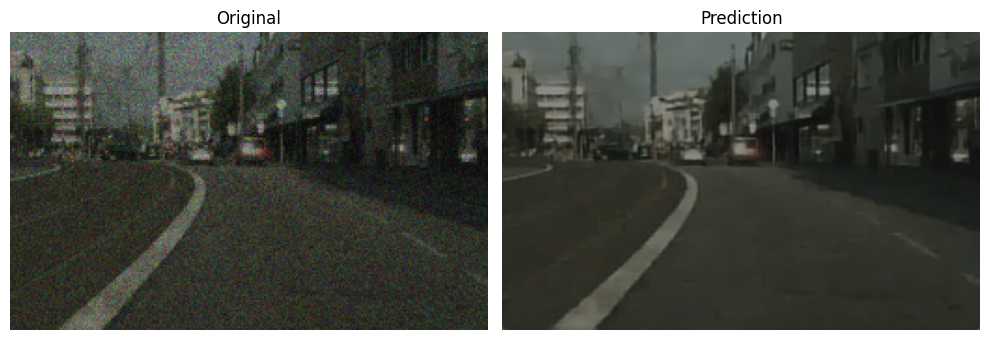

In [15]:
# File paths
idx = 'test_00030.png'
f1 = '/kaggle/input/dlp-jan-2025-nppe-3/archive/test/' + idx
f2 = '/kaggle/working/predictions/' + idx

# Load images
img1 = Image.open(f1)
img2 = Image.open(f2)

# Display side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(img2)
plt.axis('off')

plt.tight_layout()
plt.show()